# Setup

In [ ]:
#@title Carregando as bibliotecas base
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

In [ ]:
#@title Carregando os dados
data = pd.read_csv(f'/content/drive/My Drive/Mestrado/data/dados_treino_teste.csv.gz', compression='gzip', index_col=0)
data.head()

,codigo,mercado,preco_opcao,preco_exercicio,data_vencimento,T,preco_ativo,volatilidade,taxa_juros,black_scholes,delta_black_scholes,base
2015-01-05,PETRM17,OPÇÕES DE VENDA,8.18,16.91,2015-01-19,0.039683,8.61,0.771953,0.1157,8.22,100,treino
2015-01-05,PETRM28,OPÇÕES DE VENDA,0.36,8.41,2015-01-19,0.039683,8.61,0.771953,0.1157,0.41,40,treino
2015-01-05,PETRM2,OPÇÕES DE VENDA,0.02,4.91,2015-01-19,0.039683,8.61,0.771953,0.1157,0.00,0,teste
2015-01-05,PETRM23,OPÇÕES DE VENDA,0.79,9.21,2015-01-19,0.039683,8.61,0.771953,0.1157,0.87,63,treino
2015-01-05,PETRM25,OPÇÕES DE VENDA,1.13,9.61,2015-01-19,0.039683,8.61,0.771953,0.1157,1.16,73,treino


# Engenharia das variáveis (Feature Engineering)

Essa sessão é composta da transformação dos dados para entrada na rede na rede neural. Portando, as variáveis são transformadas do seu valor original, seja para adequação dentro da rede neural ou para um melhor treinamento da rede, essas transformações são:

- Variavéis númericas foram normalizadas antes da entrada na rede
- Variável categórica sofreu one hot encoding

A transformação dos dados é feita no mesmo momento que o modelo é treinado, isso é feito através da criacão de um modelo que não diferenciado numéricamente e vai somente processar os dados de entrada. 

In [ ]:
#@title Definir subset para o modelo
cols = ['preco_exercicio', 'preco_ativo', 'T', 'volatilidade', 'taxa_juros', 'mercado', 'preco_opcao']
features = data[cols].copy()
labels = features.pop('preco_opcao')

In [ ]:
#@title Definir variáveis de entrada
inputs = {}

for name, column in features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

In [ ]:
#@title Definir variáveis númericas e normalizar
numeric_inputs = {name: input for name, input in inputs.items() if input.dtype==tf.float32}

x = tf.keras.layers.Concatenate(name='concatenate_numeric')(list(numeric_inputs.values()))
norm = tf.keras.layers.experimental.preprocessing.Normalization()
norm.adapt(np.array(data[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

preprocessed_inputs = [all_numeric_inputs]

In [ ]:
#@title Definir categóricas e aplicar one hot encoding
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue
  
    lookup = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=np.unique(features[name]))
    one_hot = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

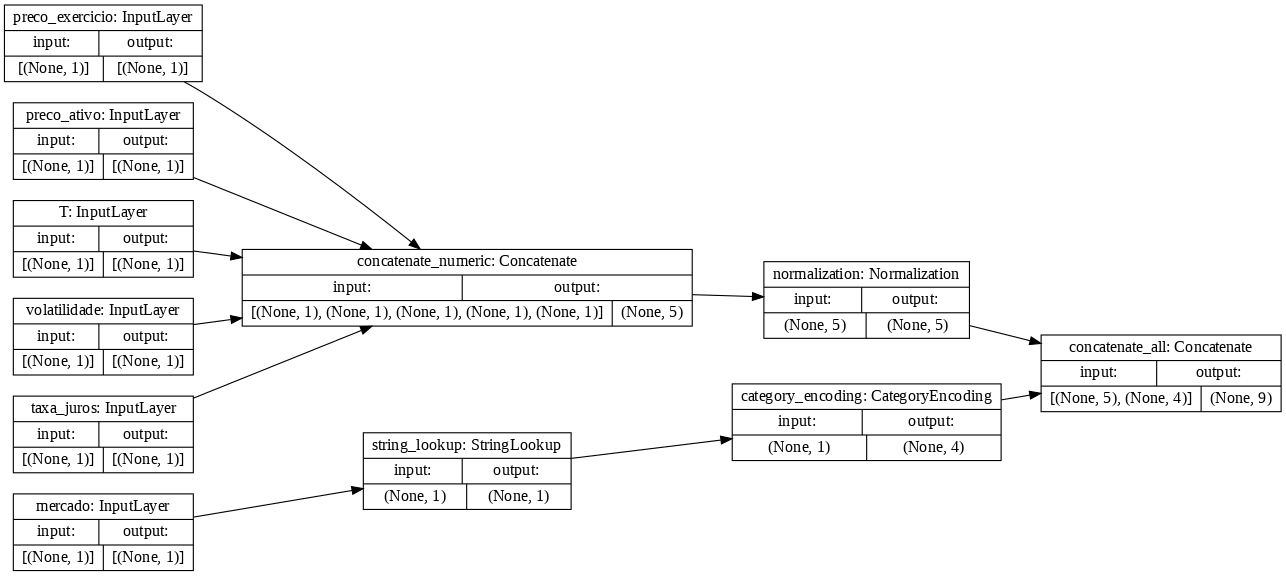

In [ ]:
#@title Concatenar dados de entrada e criar modelo para processamento das variavéis
preprocessed_inputs_concat = tf.keras.layers.Concatenate(name='concatenate_all')(preprocessed_inputs)
model_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_concat)
tf.keras.utils.plot_model(model=model_preprocessing, rankdir="LR", dpi=80, show_shapes=True)

In [ ]:
#@title Amostra de dados processados
sample_features_dict = {name: np.array(value) for name, value in features.items()}
sample_features_dict = {name: values[:1] for name, values in sample_features_dict.items()}
model_preprocessing(sample_features_dict)

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[-0.16609144, -1.262118  , -0.5997047 ,  1.6308359 ,  0.5813974 ,
         0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)>

In [ ]:
#@title tf.Data
def df_to_dataset(dataframe, base, shuffle=True, batch_size=22):

    dataframe = dataframe.copy()
    dataframe = dataframe[dataframe['base'] == base]
    labels = dataframe.pop('preco_opcao')
    cols = ['mercado', 'preco_exercicio', 'preco_ativo', 'T', 'volatilidade', 'taxa_juros']
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe[cols]), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    return ds.batch(batch_size)

# Divisão da base de treino e teste
train_ds = df_to_dataset(data, base='treino')
test_ds = df_to_dataset(data, shuffle=False, base='teste')

# Modelo

O modelo de rede neural profunda a seguir, foi baseado nos estudos desenvolvidos por Hirsa, Karatas, & Oskoui. No trabalho são testadas diversas arquiteturas (camadas e elementos em cada camada), bem como função de atição de cada camada e também função de otimização.

A conclusão do estudo mostra que os melhores resultados foram obtidos utilizando uma rede de 4 camadas com 120 neurônios cada uma.

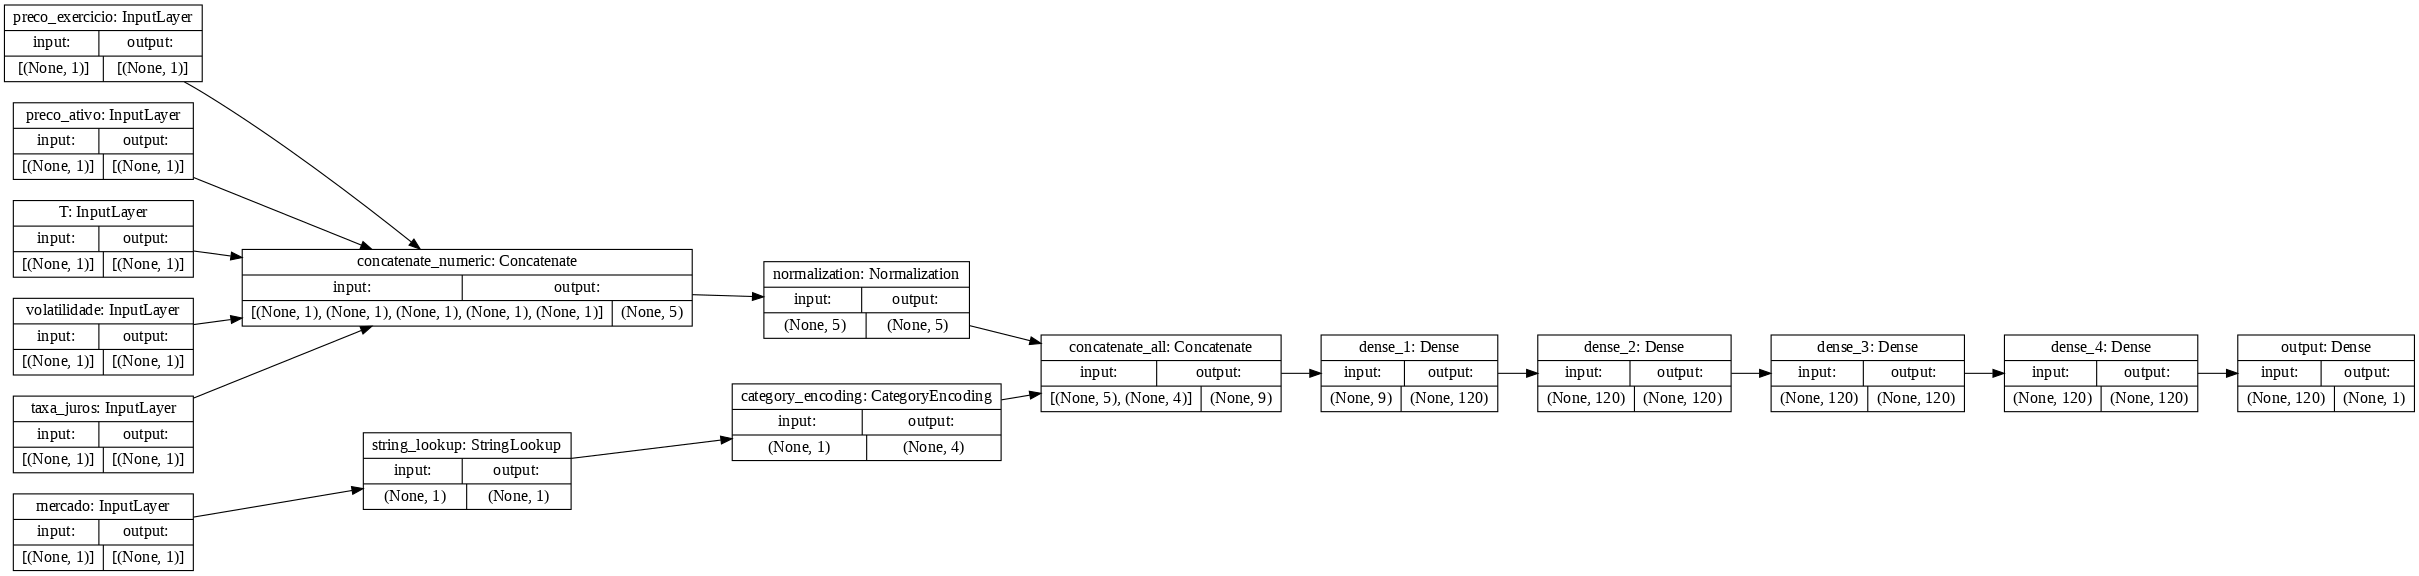

In [ ]:
#@title Model Subclassing
h = tf.keras.layers.Dense(120, activation='relu', name='dense_1')(preprocessed_inputs_concat)
h = tf.keras.layers.Dense(120, activation='relu', name='dense_2')(h)
h = tf.keras.layers.Dense(120, activation='relu', name='dense_3')(h)
h = tf.keras.layers.Dense(120, activation='relu', name='dense_4')(h)
outputs = tf.keras.layers.Dense(1, name='output')(h)

# Create an instance of the model
model = tf.keras.Model(inputs, outputs)
tf.keras.utils.plot_model(model=model, rankdir="LR", dpi=80, show_shapes=True)

In [ ]:
#@title Inicialização do modelo
# Para apresentar o sumário do modelo, primeiramente, é necessário inicializar os pesos e bias de cada camada,
# isso é feito utilizando uma amostra dos dados
element = next(iter(train_ds.take(1)))[0]
model(element)

<tf.Tensor: shape=(22, 1), dtype=float32, numpy=
array([[-0.00240594],
       [ 0.10753192],
       [ 0.13241643],
       [ 0.12489552],
       [ 0.07033569],
       [ 0.11454055],
       [ 0.09329481],
       [ 0.01969269],
       [ 0.05974363],
       [ 0.10202228],
       [ 0.08539917],
       [ 0.03332774],
       [ 0.07158932],
       [ 0.04696823],
       [ 0.11426218],
       [ 0.04573654],
       [ 0.100054  ],
       [ 0.06692667],
       [ 0.06412493],
       [ 0.20650095],
       [ 0.09487115],
       [ 0.0788302 ]], dtype=float32)>

In [ ]:
#@title Sumário do modelo
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
preco_exercicio (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
preco_ativo (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
T (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
volatilidade (InputLayer)       [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
#@title Função de perda e otimizador
loss_object = tf.keras.losses.MeanSquaredError(reduction="auto", name="mse")
optimizer = tf.keras.optimizers.Adam(0.001)

In [ ]:
#@title Métricas
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_mae')
val_loss = tf.keras.metrics.Mean(name='test_loss')
val_mae = tf.keras.metrics.MeanAbsoluteError(name='test_mae')

metrics = [train_loss, train_mae, val_loss, val_mae]

In [ ]:
#@title Aplicando gradiente
@tf.function
def train_step(data, labels):
    with tf.GradientTape() as tape:
        predictions = model(data, training=True)
        loss = loss_object(predictions, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_mae(labels, predictions)

In [ ]:
#@title Função de teste
@tf.function
def test_step(data, labels):
  predictions = model(data, training=False)
  v_loss = loss_object(labels, predictions)

  val_loss(v_loss)
  val_mae(labels, predictions)

In [ ]:
#@title Treinamento do modelo
epochs = 2

# Dicionário com as métricas
metric_dict = {
    'epoch': [],
    'loss': [],
    'mae': [],
    'val_loss': [],
    'val_mae': []
}

for epoch in range(epochs):
    # Re-inicia as métricas a cada época
    [metric.reset_states() for metric in metrics]

    for train_data, train_labels in train_ds:
        train_step(train_data, train_labels)

    for test_data, test_labels in test_ds:
        test_step(test_data, test_labels)

    metric_dict['epoch'].append(epoch)
    metric_dict['loss'].append(train_loss.result().numpy())
    metric_dict['mae'].append(train_mae.result().numpy())
    metric_dict['val_loss'].append(val_loss.result().numpy())
    metric_dict['val_mae'].append(val_mae.result().numpy())

    print(f"Epoch: {epoch + 1:2},\tloss: {train_loss.result():10.6f},\tmae: {train_mae.result():10.6f},\tval_loss: {val_loss.result():10.6f},\tval_mae: {val_mae.result():10.6f}")

Epoch:  1,	loss:   0.064020,	mae:   0.141739,	val_loss:   0.057652,	val_mae:   0.124602
Epoch:  2,	loss:   0.058508,	mae:   0.132818,	val_loss:   0.056946,	val_mae:   0.122551


In [ ]:
# Predição na base de teste
prediction = model.predict(test_ds)

data.loc[data['base'] == 'teste', 'dnn'] = prediction
data[data['base'] == 'teste']

In [ ]:
#@title Salvar predição
np.savez_compressed('/content/drive/My Drive/Mestrado/data/predicao_dnn.npz', dnn=prediction)

# Reference

Hirsa, A., Karatas, T., & Oskoui, A. (2019). Supervised deep neural networks (DNNS) for pricing/calibration of vanilla/exotic options under various different processes.